I was going through my instagram newsfeed, when I came across this short video on Ray Dalio's Holy Grail approach to portfolio construction. In the video, ray dalio mentions the impact of portfolio diversification on the volatility. You can watch the video here: https://www.youtube.com/watch?v=Nu4lHaSh7D4&ab_channel=Investopedia

In this notebook, I will be working with S&P data to identify stocks that yield a similar return over the given period to see the impact on portfolio volatility (risk) w.r.t the number of stocks in the portfolio for a given correlation bandwith(low,medium and high. 


<img src=https://acquirersmultiple.com/wp-content/uploads/2020/02/holy.jpg width="500">

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.xkcd()

SP_500 = pd.read_excel("SP_500_data.xlsx")
SP_500.set_index('Date', inplace=True)
corr_matrix = SP_500.corr().abs()

In [2]:
SP_return = ((SP_500 - SP_500.shift(1))/SP_500.shift(1)) # Calculating S&P return
SP_stocks_return = pd.DataFrame() 
SP_stocks_return['annual_return'] = (SP_return.mean()*250) # Calculating S&P stocks annual return 
SP_stocks_return['annual_vol'] = (SP_return.std())*np.sqrt(250) # Calculating S&P stocks annualized volatility

#Extracting a stocks with a specific range of annualized returns  - In my case I am using a range of 10% with +- 1%
return_10_pct  = SP_stocks_return[(SP_stocks_return['annual_return'] > 0.09) & (SP_stocks_return['annual_return'] <= 0.11)]
return_10_pct

,annual_return,annual_vol
ADM,0.090801,0.252544
AIG,0.103249,0.358850
AMCR,0.099760,0.253526
CAH,0.105150,0.265950
CHRW,0.090704,0.236984
CMA,0.102614,0.340571
CNP,0.098852,0.250760
CVS,0.108733,0.236642
CXO,0.095412,0.410639
DISH,0.108153,0.353511


For this exercise - I will by starting of with a buy-and-hold portfolio consisting of AIG stocks

In [3]:
stocks_pct_return_10 = list(return_10_pct.index) ## collecting ticker of stocks that yield annual return of 10%
stocks_pct_return_10.remove('AIG') ## removing AIG from the list as it is going to be in my base case

In [4]:
## getting correlation of stocks with AIG that yield 10%
AIG = corr_matrix['AIG'] # get the column for the correlation dataframe
AIG = ((AIG.to_frame().transpose())[stocks_pct_return_10]) # select stocks that are in the 10% yield range
AIG = ((AIG.transpose()).sort_values(by='AIG')).join(return_10_pct)
AIG.columns = ['correlation_AIG','annual_ret','annual_vol']
AIG.head()

,correlation_AIG,annual_ret,annual_vol
NRG,0.151899,0.106616,0.357102
NTAP,0.217123,0.100442,0.344129
CHRW,0.494409,0.090704,0.236984
PEG,0.596266,0.101232,0.207268
PWR,0.609728,0.105924,0.319562


Now I will be labelling correlation ranges. Since I have a limited number of stocks to work with I have defined ranges as follows:
  When correlation is between 0-0.65:    <b>low </b>
  When correlation is between 0.65-0.79: <b>medium</b>
  When correlation is between 0.79-1:    <b>high</b>


<u><i>Note:</i></u>  These ranges are defined for the purpose of this exercise. In reality, it will be categorized very differently

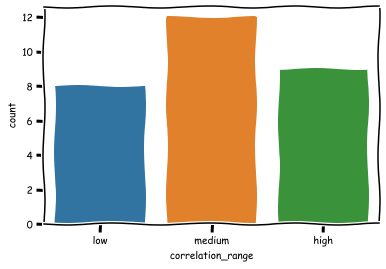

In [6]:
import seaborn as sns
bins=[0,0.65, 0.79, 1]
group_names = ['low', 'medium', 'high']
AIG['correlation_range'] = pd.cut(AIG['correlation_AIG'], bins=bins, labels=group_names)
AIG['correlation_range'].unique()
ax = sns.countplot(x="correlation_range", data=AIG)

In [7]:
low = AIG[AIG['correlation_range']=="low"]
medium = AIG[AIG['correlation_range']=="medium"]
high = AIG[AIG['correlation_range']=="high"]

In [8]:
low

,correlation_AIG,annual_ret,annual_vol,correlation_range
NRG,0.151899,0.106616,0.357102,low
NTAP,0.217123,0.100442,0.344129,low
CHRW,0.494409,0.090704,0.236984,low
PEG,0.596266,0.101232,0.207268,low
PWR,0.609728,0.105924,0.319562,low
AMCR,0.625413,0.099760,0.253526,low
ED,0.625786,0.105434,0.187163,low
KO,0.643438,0.099669,0.173331,low


In [11]:
list_volatility = []
list_cor_range = [low, medium, high]
amount_invested = 1000
for i in list_cor_range:
    lst1 = (list(i.index))
    lst1.insert(0,'AIG')
    df = SP_return[lst1]
    df = df.fillna(method='ffill')
    df= df.fillna(1) 

    ## USing data from last 1500 days
    df = df[-1500:]

    # returns.dropna(inplace=True)
    df=df+1
    df = df[:-1]
    initial_investment = 1000
    list_vol = []
    for j in range(1,(df.shape[1]+1)):
        stocks = list(df.columns[0:j])
        portfolio_return =((amount_invested/j)*((df[stocks]).cumprod())).sum(axis=1)    
        average_return = ((portfolio_return - portfolio_return.shift(1))/portfolio_return.shift(1))
        annualized_volatility = average_return.std() * np.sqrt(250)
        annualized_returns =(average_return.mean() * 250)
    #     print(annualized_returns)
#         print(annualized_volatility)
        list_vol.append(annualized_volatility)
    list_volatility.append(list_vol)


In [12]:
data_plot = pd.DataFrame(list_volatility)
data_plot = data_plot.transpose()
data_plot.columns =['low_correlation','medium_correlation','high_correlation']

In [13]:
data_plot

,low_correlation,medium_correlation,high_correlation
0,0.336056,0.336056,0.336056
1,0.276448,0.209994,0.233178
2,0.261238,0.280066,0.219672
3,0.219437,0.276677,0.188104
4,0.197237,0.274950,0.183179
5,0.199982,0.262693,0.185704
6,0.187199,0.255250,0.192968
7,0.174931,0.257356,0.196671
8,0.169650,0.234610,0.204145
9,NaN,0.234754,0.206484


Text(0, 0.5, 'portfolio volatility')

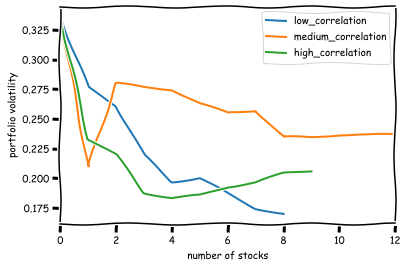

In [14]:
ax = data_plot.plot()
ax.set_xlabel("number of stocks")
ax.set_ylabel("portfolio volatility")

<b>This is still a work in progress</b>